## Insurance 회귀 분석 캡스톤
- 왜 어떤 사람의 의료보험 청구 비용은 높고 낮을까?
    - 나이, 성별, 거주 지역, 생활 습관에 따라 달라짐
    - 흡연 여부는 의료비를 얼마나 크게 변화시킬까?
    - 젊은 사람도 흡연자라면 높은 비용을 지불할까?
    - 개인의 인구학적 건강 특성이 의료보험 청구 비용을 어떤 구조로 설명하는지를 데이터와 회귀모형을 통해 단계적으로 탐구
    - 목표는 "의료 비용 불평등은 어떤 논리로 형성되는가" 를 수치와 언어로 설명하는 것

In [88]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore,probplot, pearsonr, spearmanr
from scipy.stats import shapiro, skew,kurtosis,normaltest,bartlett,levene, ttest_rel, mannwhitneyu,ttest_ind
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statannotations.Annotator import Annotator
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_gameshowell, pairwise_tests

from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [89]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [90]:
origin = load_data('insurance')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


===== 데이터 크기 확인 =====
데이터셋 크기 : (1338, 7)
열 개수: 7
행 개수: 1338

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [91]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- 데이터 기본 전처리 -카테고리 타입 지정
- smoker 변수 no=0, yes=1로 변경

In [92]:
df_raw = origin.copy()
df_raw = df_raw.astype({'sex':'category','smoker':'category', 'region':'category'})

display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


None

In [93]:
#smoker 변수 0과 1로 변환
df_raw['smoker'] = np.where(df_raw['smoker']=='yes', 1, 0)
df_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,0,northwest,10600.54830
1334,18,female,31.920,0,0,northeast,2205.98080
1335,18,female,36.850,0,0,southeast,1629.83350
1336,21,female,25.800,0,0,southwest,2007.94500


### 미션 1. 이 데이터는 믿을만할까?
- 결측, 이상치, 편향을 점검하고, 처리 기준을 제시한다.
- charges가 음수이거나 극단값인지, age/bmi 등의 범위가 현실적인지 확인한다.
- 범주형 변수(sex, smoker, region)가 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 몰려 있지는 않는지 확인한다.
- 전처리 전,후가 어떻게 달라졌는지 한 눈에 비교하는 표나 요약을 만든다.
- 단위 해석 주의 : charges는 USD이므로 현실적인 의료비 수준인지 평가하세요.

#### 기술통계량 확인

In [94]:
# 수치형 요약 통계를 확인함
df_raw.describe()

,age,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,13270.422265
std,14.049960,6.098187,1.205493,0.403694,12110.011237
min,18.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,53.130000,5.000000,1.000000,63770.428010


데이터의 평균 분포가 서로 상이하므로 (특히 나이와 bmi) 로그나 데이터 표준화 등의 처리가 필요할듯

#### 2. 결측치 비율 확인

In [95]:
# 결측률을 내림차순으로 확인함
df_raw.isna().mean().sort_values(ascending=False)*100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

- 결측치가 없음 ! ! ! 대박

#### 3. 중복행수

In [96]:
#중복 행 수를 집계함
df_raw.duplicated().sum()

np.int64(1)

중복 행이 하나 존재하므로 삭제

In [97]:
# 중복 행을 삭제함
df = df_raw.drop_duplicates().reset_index(drop=True)
df.shape

(1337, 7)

#### 4. charges의 값이 음수,극단인지, age/bmi의 범위가 현실적인지 확인

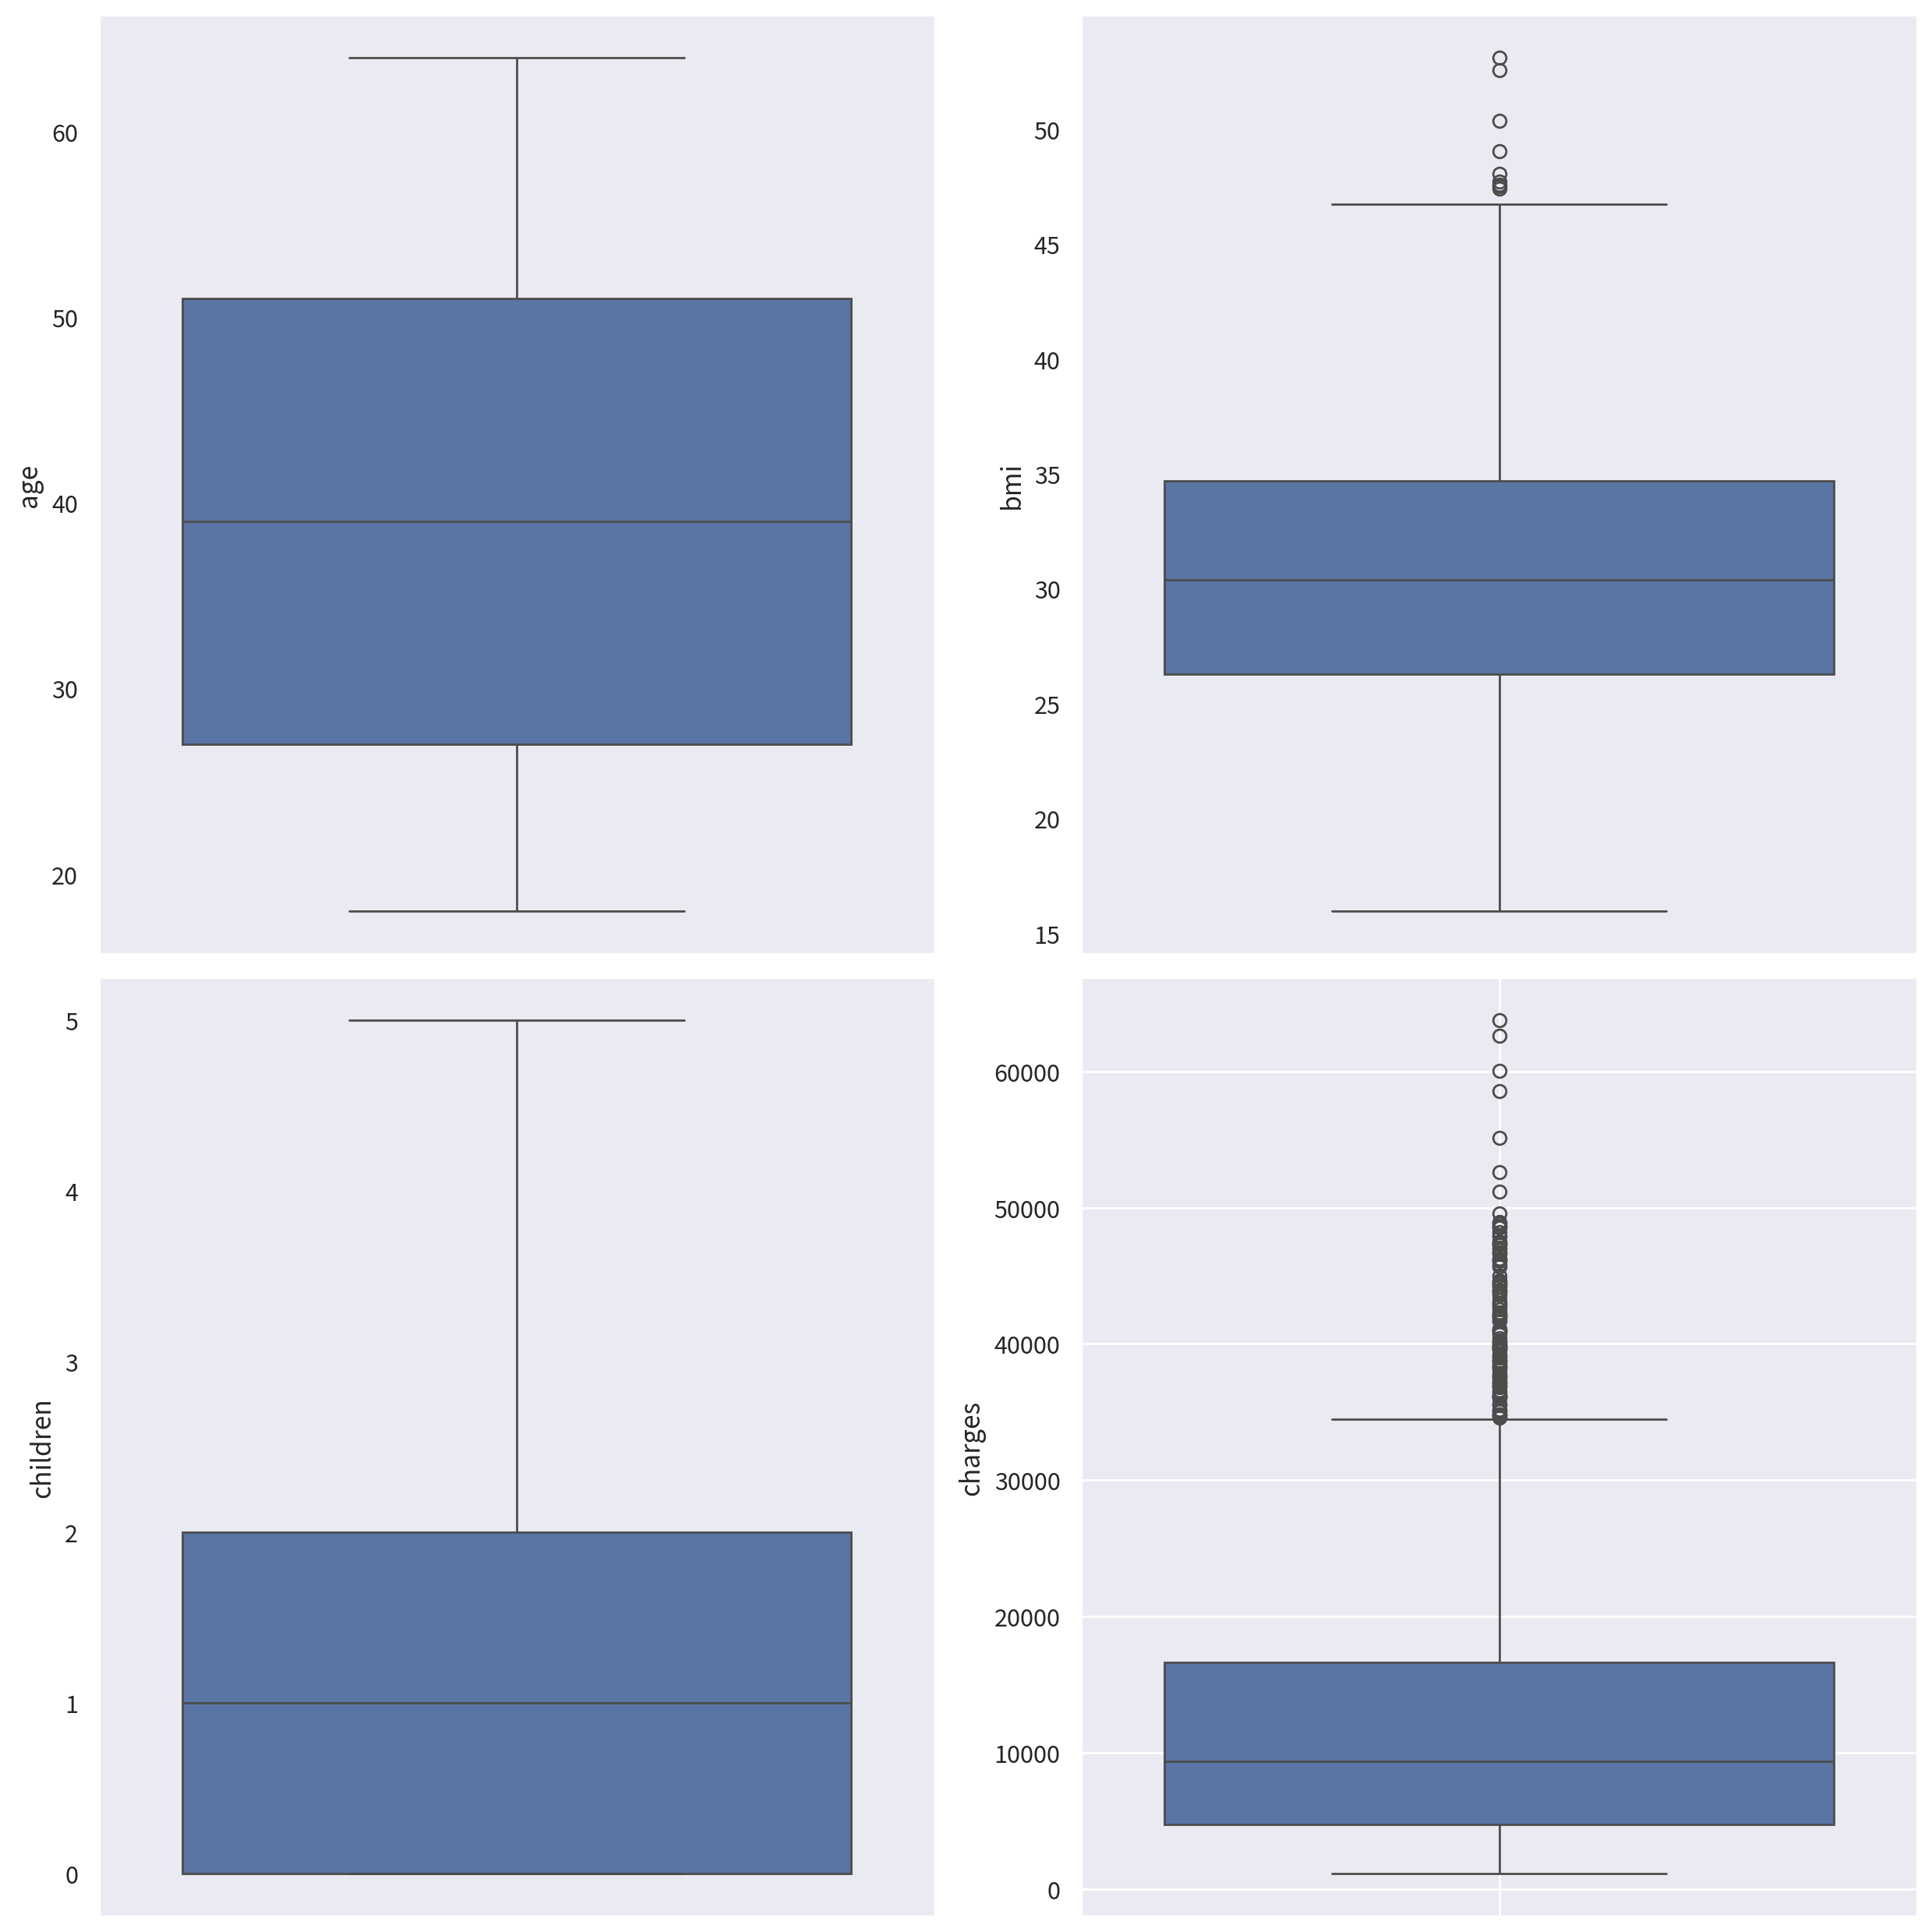

In [98]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df['age'],orient='v',ax=ax[0][0])
sb.boxplot(data=df['bmi'],orient='v',ax=ax[0][1])
sb.boxplot(data=df['children'],orient='v',ax=ax[1][0])
sb.boxplot(data=df['charges'],orient='v',ax=ax[1][1])
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- BMI에 이상치가 발견되는데 max값이 53으로 현실적인 범위라고 생각할 수 있음. 
- 몸무게=55 x 키m^2 이니까 
    - 키가 160인 사람이 140.8키로 나가면 가능..
- charges의 최댓값이 63770USD 로 우리나라 돈으로 93,226,638원임.. 미국이라고 생각해도 값이 좀 이상한 느낌 하지만, 3.5만 달러~ 5만달러까지 데이터가 꽤 몰려있는 것을 보면 6만달러가 말이 안되는 가격이 아닐 수 있음.
    - 일단 그대로 두고 분석 진행

### 미션 2. 의료비와 핵심 변수의 첫인상
- 1. charges, age, bmi, children 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다.
- 2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술하시오.
- 3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
- 4. 의료비의 long-tail 분포(극단적 고액 청구)가 해석에 미치는 영향도 짧게 언급하세요.

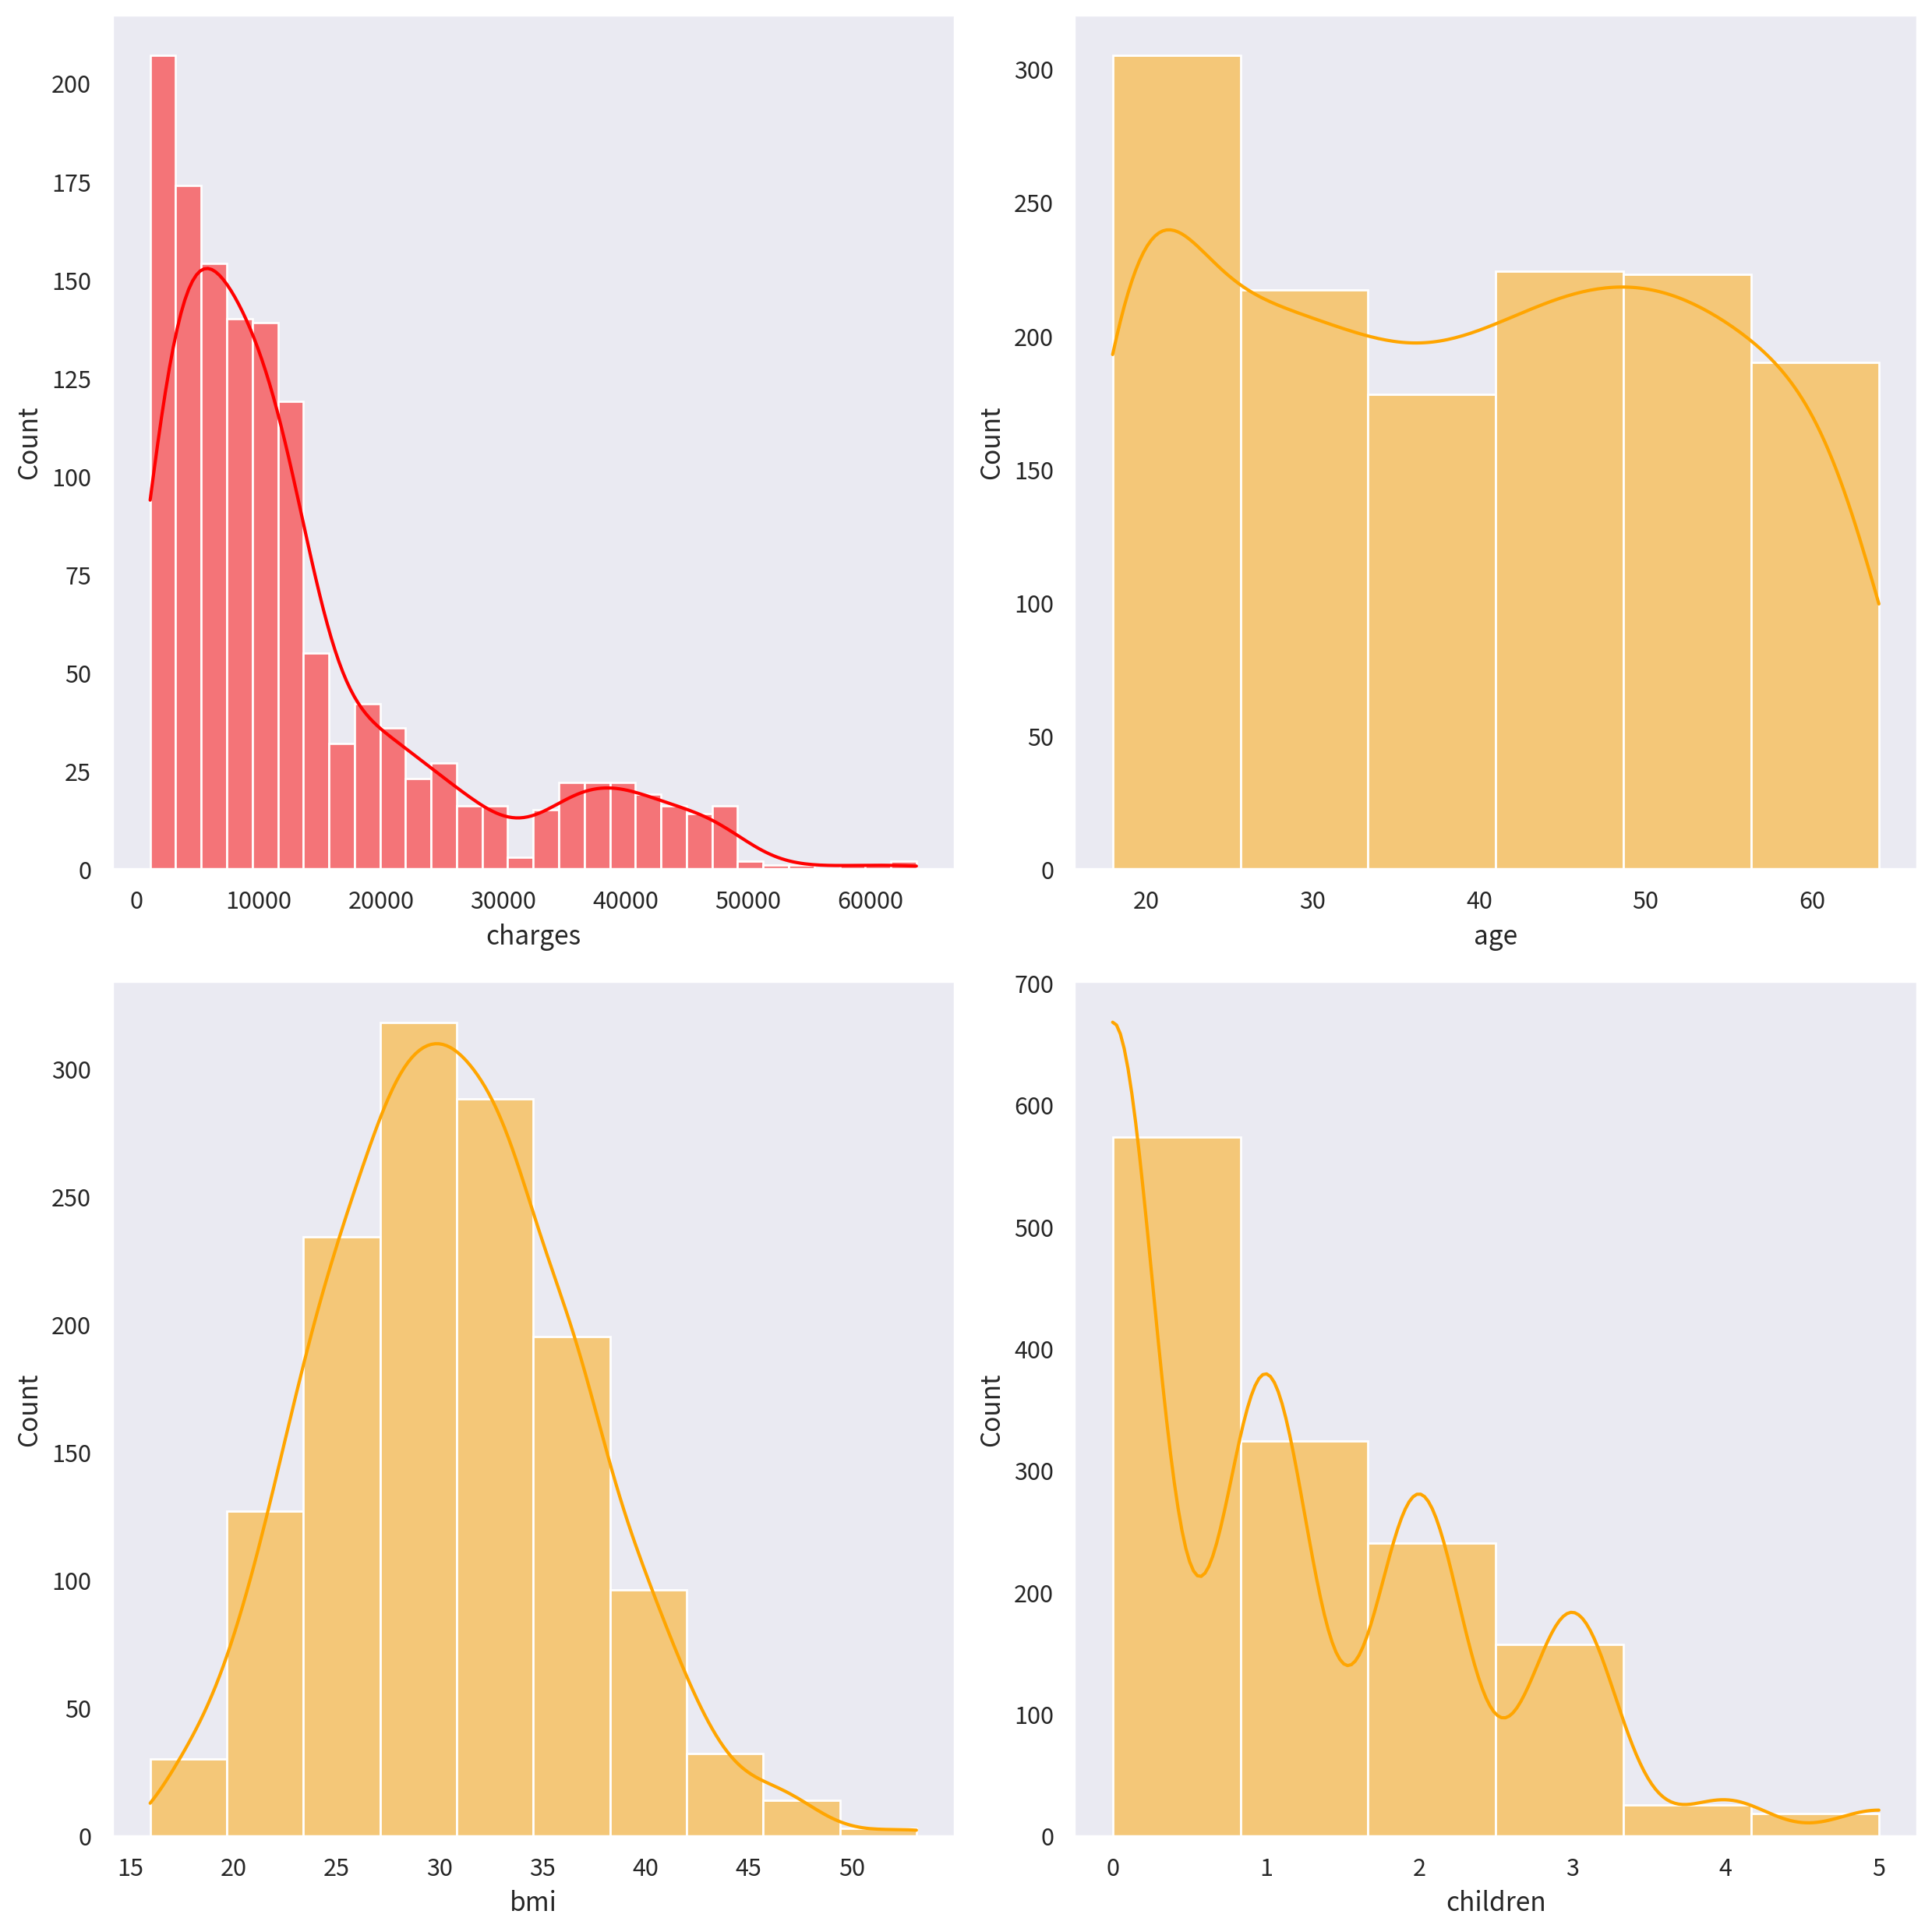

In [99]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='charges', bins=30, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df, x='age', bins=6, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df, x='bmi', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df, x='children', bins=6, kde=True, color='orange', ax=ax[1,1])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 대부분의 charges는 0~15000USD를 지불하는 듯 
    - 일부 고액을 내는 사람이 존재 (20000~50000)
    - 왼쪽으로 치우쳐져있음
- 나이대는 20대가 가장 많고 50대가 그 다음, 나머지 30,40,60대는 비슷함
- bmi 지수는 25~35 사이에 몰려있으며 정규 분포 형태를 띔
- 아이들은 1명 이하인 사람이 많은 것을 알 수 있음. 
    - 왼쪽으로 치우쳐져있음.

### 미션 3. 로그/비선형 변환을 고민해보자.

- charges 혹은 주요 변수(age, bmi, children)에 로그/제곱근 등 변환을 적용해 전후 분포를 나란히 비교한다.
- 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상한다.
- 이 변환이 없으면 어떤 함정에 빠질까?를 한 줄로 정리한다.
- 선택 기준을 명시하세요. 왜 log(charges)인지, 왜 특정 변수에 변환을 적용하는지 데이터 분포 근거로 설명합니다.

charges에 로그 변환 적용, bmi는 왜도가 심하지 않고 children은 변환의 필요를 못느낌, 실제 값을 사용하는게 더 좋을듯이라고 일단 생각하고 진행

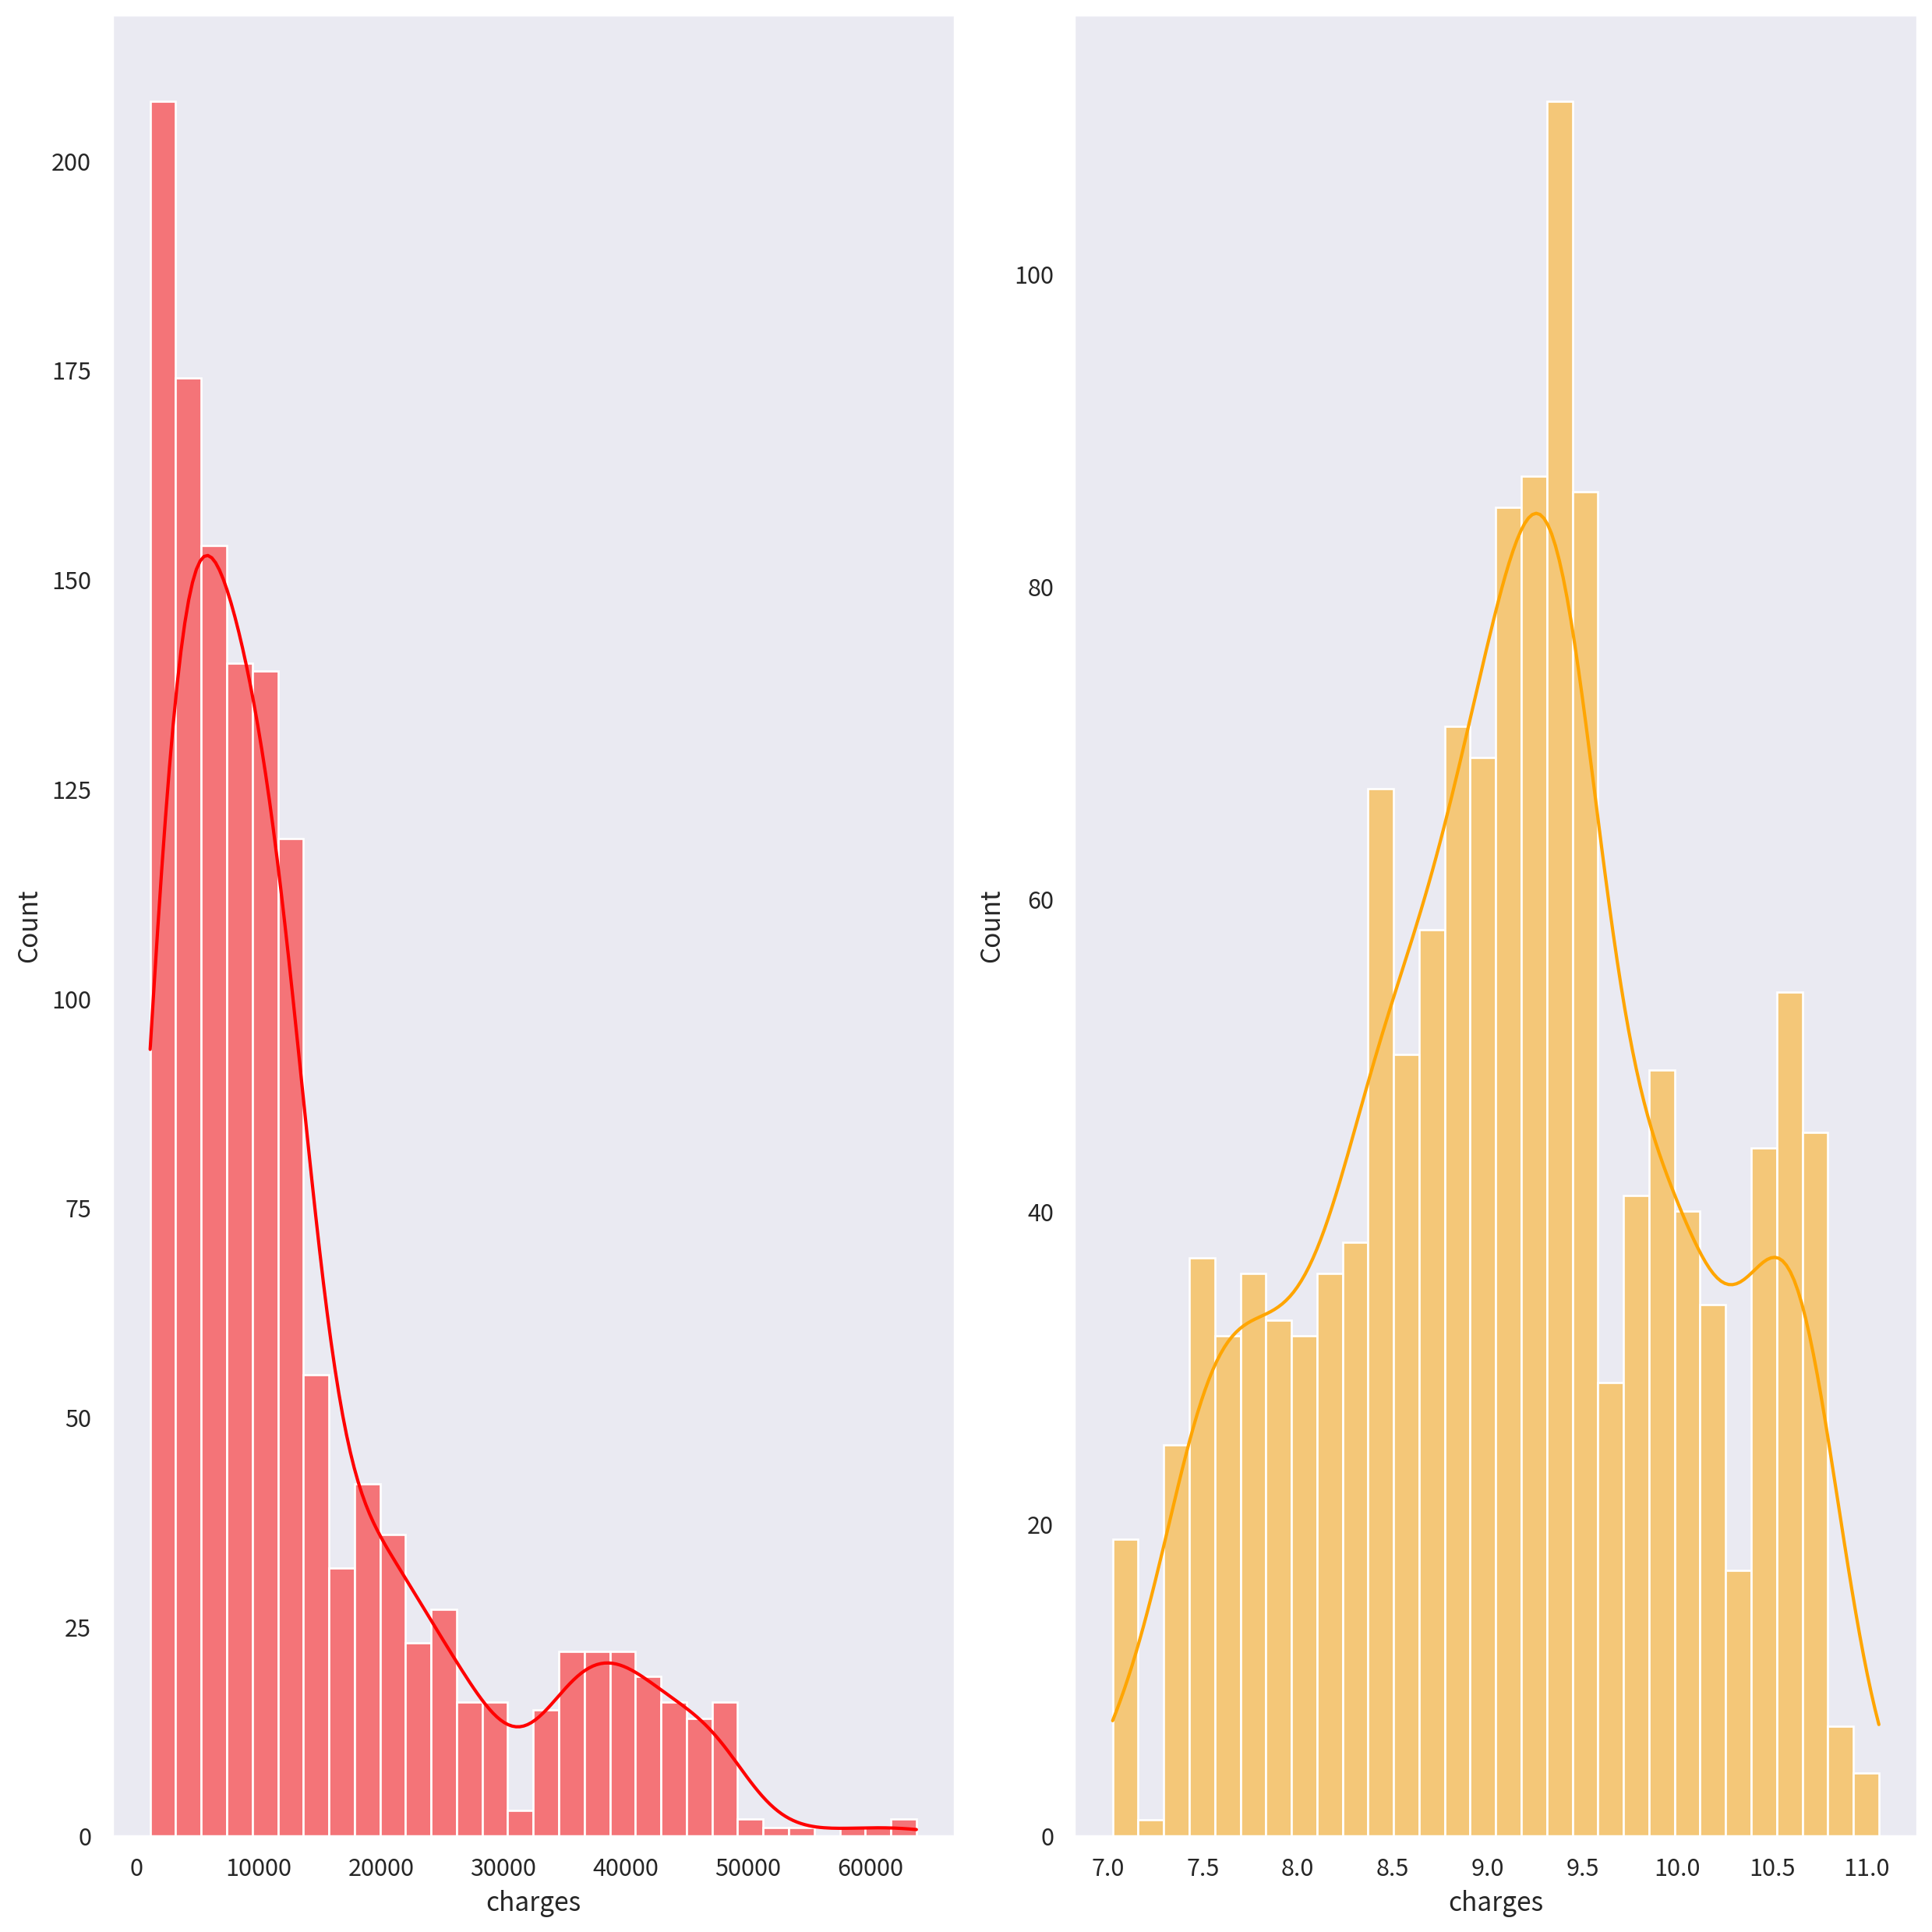

In [100]:
#charges 변수에 로그 변환 적용
df2=df.copy()
df2['charges'] = np.log1p(df2['charges'])

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='charges', bins=30, kde=True, color='red', ax=ax[0])
sb.histplot(data=df2, x='charges', bins=30, kde=True, color='orange', ax=ax[1])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 의료비의 대부분이 소액에 집중되어 있기 때문에 오른쪽 꼬리가 생김
- 로그 변환을 적용하여 정규 분포에 가까운 형태로 만들어줌
    - 모델이 고액 데이터들(이상치)에게로부터 안정적으로 학습할 수 있음 
    - 로그 변환을 하지 않을 경우 이상치가 모델 전체를 왜곡시켜 대다수 일반 사용자의 의료비를 과대, 과소로 예측하게 될 수 있음.

### 미션 4. 성별과 거주 지역은 의료비를 결정할까?
- 성별(sex)과 지역(region)별 의료비 분포를 시각화(박스플롯, 바이올린 플롯)한다.
- 중앙값, 분포 겹침을 근거로 어느 집단이 비싼가? 차이가 얼마나 뚜렷한가? 를 문장으로 적으세요.
- 왜 이런 차이가 생겼을까?를 건강보험 체계,지역 의료 인프라, 생활 비용 차이 등으로 추정해보세요.

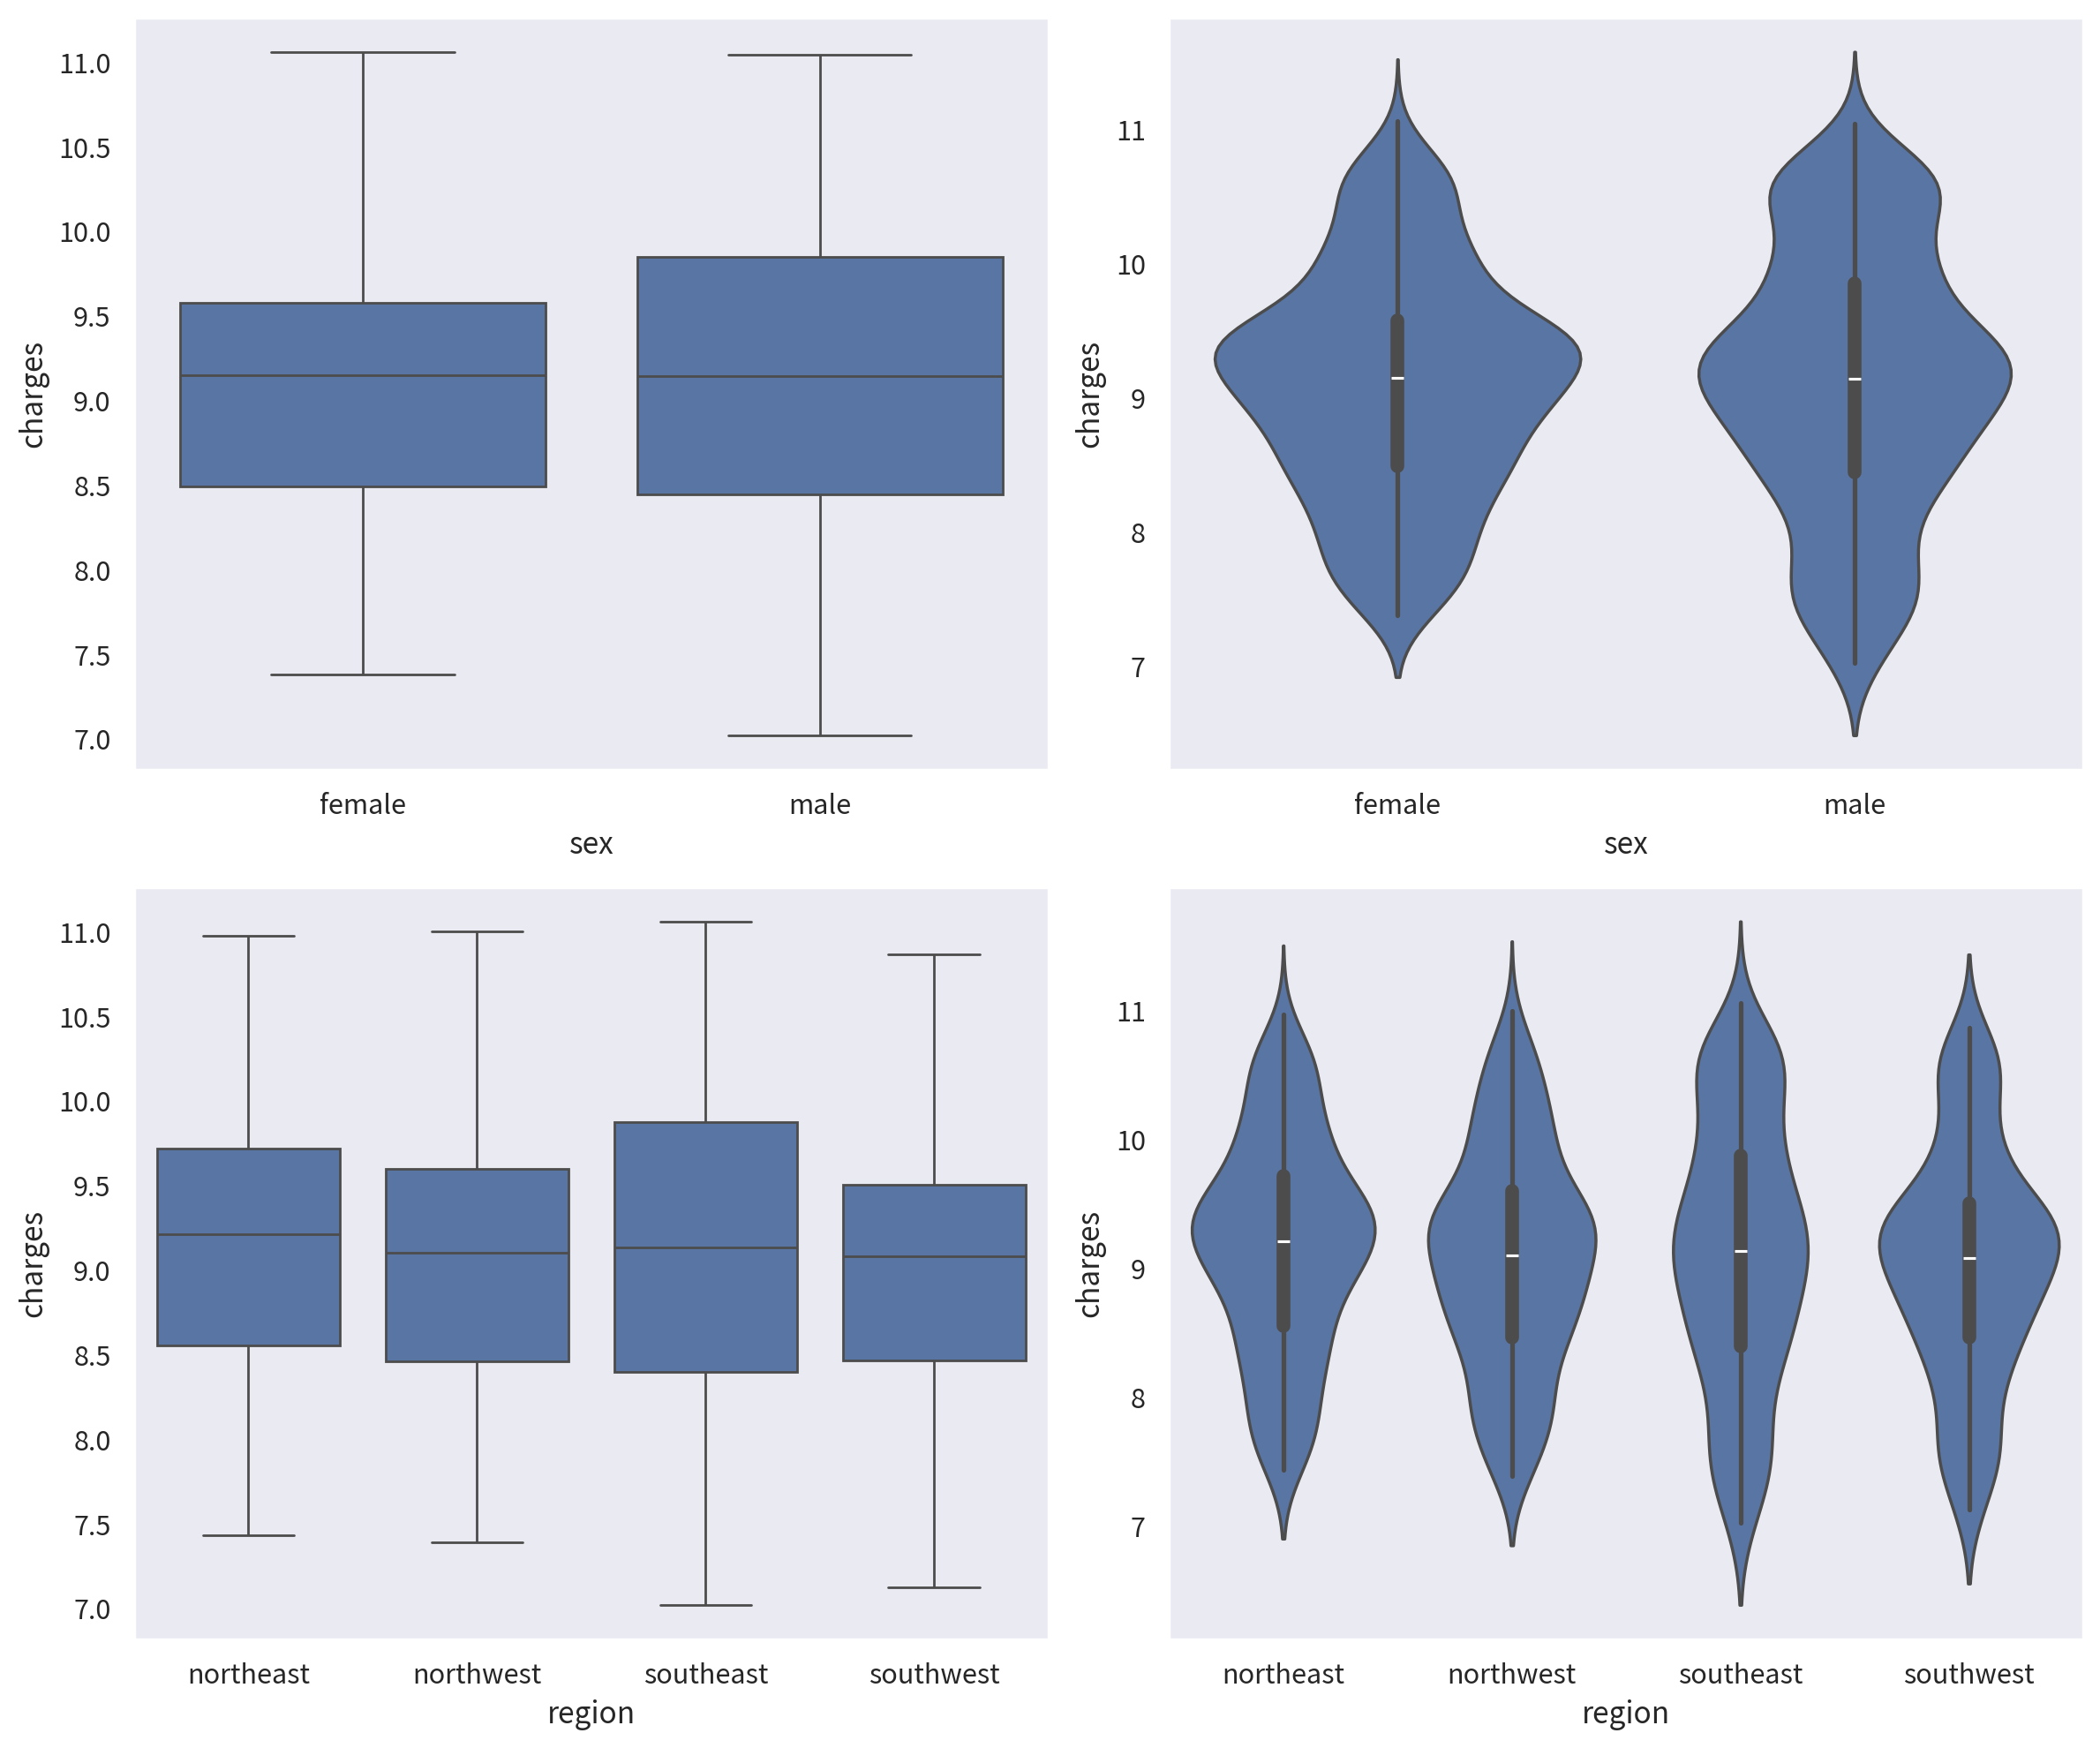

In [101]:
#성별과 지역별 의료비 분포 시각화 (박스플롯, 바이올린 플롯)
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=my_dpi)
sb.boxplot(data=df2, x='sex', y='charges', ax=ax[0][0])
sb.violinplot(data=df2, x='sex', y='charges', ax=ax[0][1])
sb.boxplot(data=df2, x='region', y='charges', ax=ax[1][0])
sb.violinplot(data=df2, x='region', y='charges', ax=ax[1][1])  

plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료


- 성별의 경우 남성과 여성 둘 다 중앙값은 비슷한 위치에 존재함
    - 남성의 경우 여성에 비해 고액이 많이 나타남
- 지역의 경우 4개 지역의 박스 높이와 위치가 비슷함
    - southeast의 경우 바이올린 플롯이 더 얇고 위로 길게 뻗어있는 것을 보아 고액 의료비를 내는 사람이 더 많음
    - 거주 지역 자체가 의료비를 결정하지는 않지만 지역별 생활 습관이나 의료 인프라 차이로 의료비 청구 비율이 달라질 수 있다고 생각함.

### 미션 5. 흡연은 정말로 의료비를 크게 높일까?
- smoker(흡연 여부)에 따라 charges가 다른지 시각화하고, 두 집단 평균 차이를 가설검정(t-test)으로 확인한다.
- 효과 크기(차이의 크기)를 함께 제시하고, 실제로 의미있는 차이인가?를 말로 해석하세요.
- 정규성/등분산 가정 점검 후 필요 시 Welch's t-test나 비모수 검정을 선택하세요.
- 효과 크기를 의료 정책 관점에서 의미를 서술합니다.

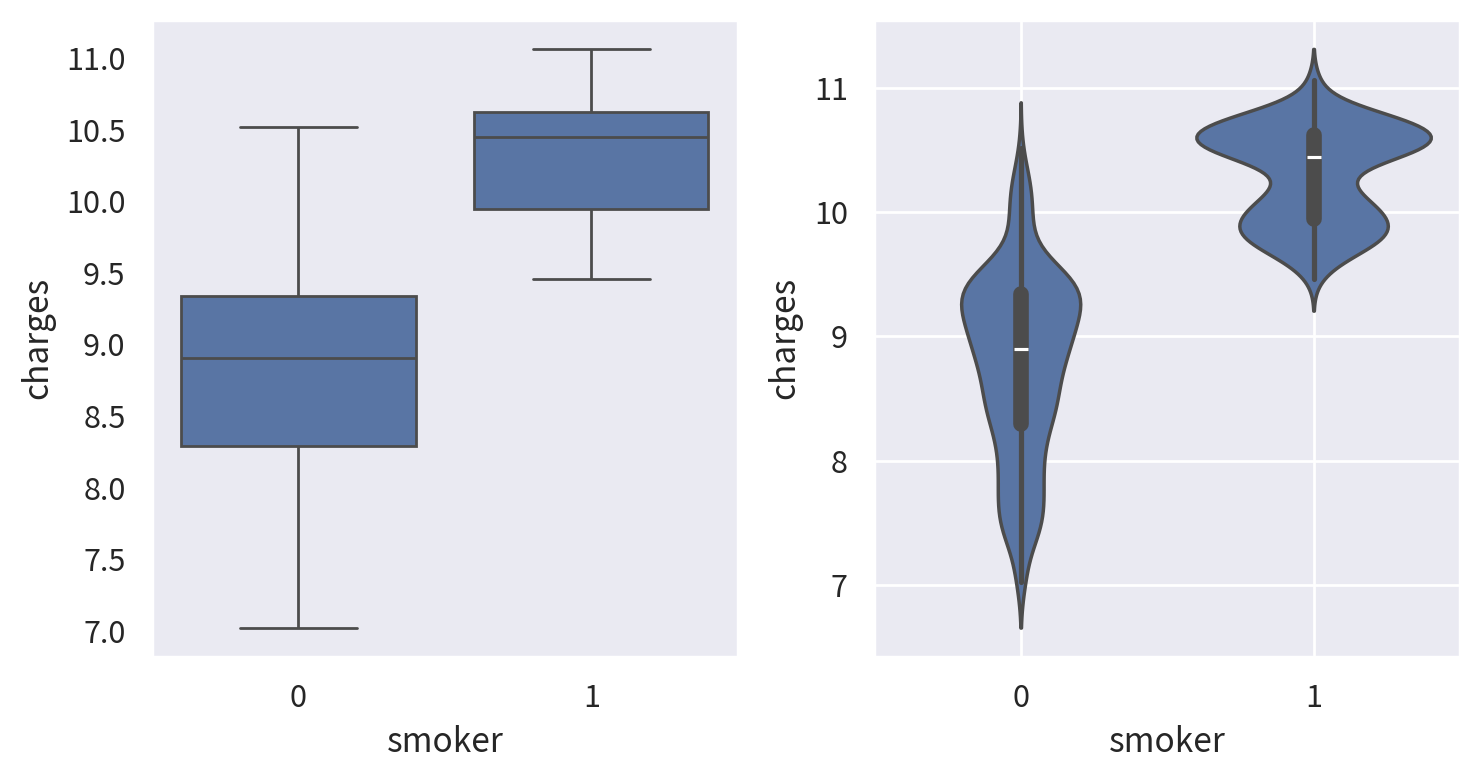

In [102]:
#smoker에 따라 charges가 다른지 시각화
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1500             #그래프 가로 크기
height_px = 800             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)
# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df2, x='smoker', y='charges', ax=ax[0])
sb.violinplot(data=df2, x='smoker', y='charges', ax=ax[1])
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)
# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료


In [103]:
#두 집단 평균 차이를 가설검정(t-test)으로 확인
smoker_1 = df2[df2['smoker']==1]['charges']
smoker_0 = df2[df2['smoker']==0]['charges']

s_1, p_1 = shapiro(smoker_1)
print("statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}".format(s_1,p_1, p_1>0.05))
s_0, p_0 = shapiro(smoker_0)
print("statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}".format(s_0,p_0, p_0>0.05))

statistic: 0.929, p-value: 0.000, 정규성 충족 여부: False
statistic: 0.976, p-value: 0.000, 정규성 충족 여부: False


정규성 충족하지 않으니 비모수 검정 진행

- 귀무가설 : 흡연자와 비흡연자의 평균 의료보험 청구 비용은 차이가 없다.
- 대립가설 : 흡연자와 비흡연자의 평균 의료보험 청구 비용은 차이가 있다.

In [104]:
#비모수 검정 Welch's t-test 수행
s,p = ttest_ind(smoker_1, smoker_0, equal_var=False)
print("statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s,p,"대립" if p<=0.05 else "귀무"))

statistic: 46.347, p-value: 0.000, 대립가설 채택


- 대립가설 채택으로 흡연자와 비흡연자의 평균 의료보험 청구 비용은 차이가 있음.
- 박스플롯의 형태만 보아도 흡연자와 비흡연자의 평균 의료보험 청구 비용은 존재한다고 유추할 수 있음.
- statistic이 의미하는 바 : 두 집단의 평균이 얼마나 멀리 떨어져있나?
    - 현재 46.347로 흡연자의 의료비가 더 높은 것을 의미함
    - 매우 유의미한 차이로 흡연은 보험료의 불평등을 초래하는 결정적인 상승 요인이며 흡연자에 대한 금연 지원 사업이 필요함을 보여줌. 
        - 흡연자들의 평균 의료보험 청구 비용이 왜 높은가? 에 대한 의문이 생김
        - 단순 흡연자들에게 보험료를 더 높게 부과하는 것일지, 흡연자들의 잔병치레가 있기에 보험비를 많이 타서 보험료가 많이 올라가는 것인지?

### 미션 6. 나이대별로 의료비 차이가 뚜렷할까?
- age를 여러구간으로 나누어(ex: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.
- 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.
- 사후검정은 Tukey HSD 또는 Games-Howell(등분산 위반 시)을 사용하고, 의료비 연령 서열표 형태로 요약하세요.

In [105]:
# 연령대 정의: 청년(18-30), 중년(31-50), 노년(51+)
bins = [0, 30, 50, 100]
labels = ['Young(18-30)', 'Middle(31-50)', 'Senior(51+)']
df2['age_group'] = pd.cut(df2['age'], bins=bins, labels=labels)

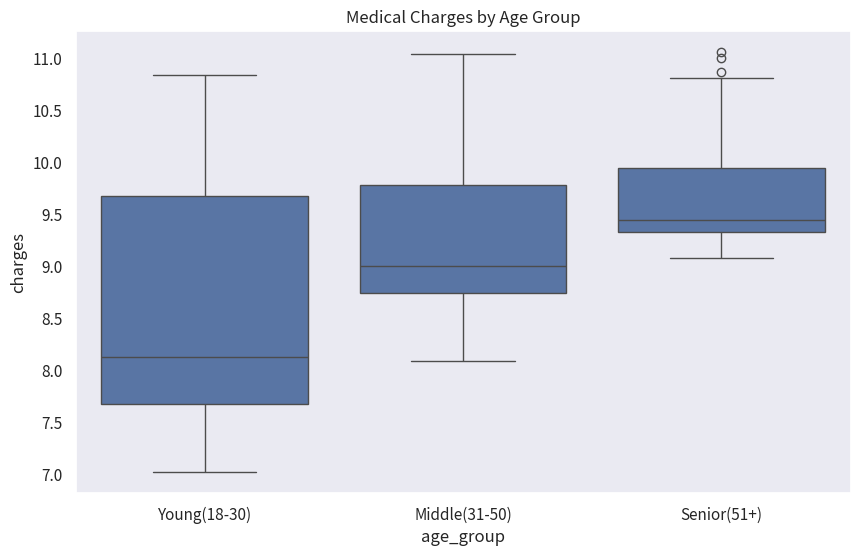

In [106]:
plt.figure(figsize=(10, 6))
sb.boxplot(x='age_group', y='charges', data=df2)
plt.title('Medical Charges by Age Group')
plt.show()

In [107]:
# 각 그룹의 데이터 분리
g1 = df2[df2['age_group'] == 'Young(18-30)']['charges']
g2 = df2[df2['age_group'] == 'Middle(31-50)']['charges']
g3 = df2[df2['age_group'] == 'Senior(51+)']['charges']

f_val, p_val = f_oneway(g1, g2, g3)
print(f"ANOVA F-statistic: {f_val:.3f}, p-value: {p_val:.3e}")

ANOVA F-statistic: 210.871, p-value: 2.653e-80


- 귀무가설 : 나이대별로 병원비 평균에는 차이가 없다.
- 대립가설 : 나이대별로 병원비 평균에는 차이가 있다.

- ANOVA분석 결과 : 그룹 간의 차이가 유의하게 존재하다는 것을 확인함.
    - F = 210.87, p-value < 0.001
    - 나이는 보험 청구액의 핵심적인 변수가 될 수 있음.

- 사후검정 실시

In [108]:
tukey = pairwise_tukeyhsd(df2['charges'], df2['age_group'], alpha=0.05)
tukey_table = tukey.summary()
tukey_df = DataFrame(tukey_table.data[1:], columns=tukey_table.data[0])
print(tukey_df)

          group1        group2  meandiff  p-adj   lower   upper  reject
0  Middle(31-50)   Senior(51+)    0.4419    0.0  0.3134  0.5703    True
1  Middle(31-50)  Young(18-30)   -0.7032    0.0 -0.8238 -0.5826    True
2    Senior(51+)  Young(18-30)   -1.1450    0.0 -1.2789 -1.0112    True


- Senior > Middle > Young 순으로 의료비가 유의미하게 높게 나타남
    - 가장 젊은 그룹과 가장 고령의 그룹의 격차가 1.14로 크게 나타남
    - 나이가 들수록 보험 청구액이 높다라고 생각할 수 있음.

### 미션 7. 변수들은 서로 섞여있을까?
- 주요 연속형 변수 간 상관행렬(age, bmi, children, charges)을 계산한다.
- 상관행렬을 히트맵으로 시각화하고, Variance Inflation Factor(VIF)로 다중공선성을 점검한다.
- age와 bmi같이 약한 상관을 보이는 변수들이 모델에 주는 정보를 논의하세요.
- 공선성 문제가 없다면 그 이유를, 있다면 완화 전략(변수 제거, 결합지표, 정규화 회귀)을 비교하세요.

In [109]:
df3 = df2.copy()
df3 = df3.drop(columns=['sex','region','age_group'])
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   bmi       1337 non-null   float64
 2   children  1337 non-null   int64  
 3   smoker    1337 non-null   int64  
 4   charges   1337 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 52.4 KB


In [110]:
skew_outlier={}
for col in df3.columns:
    temp = df3[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col]= {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }
skew_outlier_df=DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z| > 3)
age,0.054781,-0.991295,0.0
bmi,0.283914,-0.962348,4.0
children,0.937421,0.430962,18.0
smoker,1.463601,1.463601,0.0
charges,-0.089558,-0.596179,0.0


In [111]:
rows = []

for a, b in combinations(df3.columns,2):
    x = df3[a]
    y = df3[b]

    # [1] 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue>0.05

    # [2] 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z| > 3)'] >0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z| > 3)'] >0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x,y)
    else:
        chosen = 'spearman'
        corr,pval = spearmanr(x,y)

    # [4] 유의성 판단(p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # [6] 행 추가
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,age,bmi,True,True,spearman,0.107897,7.714446e-05,True,Very weak
1,age,children,False,True,spearman,0.055813,4.130067e-02,True,Very weak
2,age,smoker,True,False,pearson,-0.025587,3.498547e-01,False,Very weak
3,age,charges,False,False,spearman,0.533523,3.187756e-99,True,Medium
4,bmi,children,True,True,spearman,0.015643,5.676589e-01,False,Very weak
5,bmi,smoker,True,True,spearman,0.002216,9.354915e-01,False,Very weak
6,bmi,charges,True,True,spearman,0.119585,1.163718e-05,True,Very weak
7,children,smoker,True,True,spearman,0.016199,5.539720e-01,False,Very weak
8,children,charges,False,True,spearman,0.132200,1.230376e-06,True,Very weak
9,smoker,charges,False,False,spearman,0.663611,1.721413e-170,True,Strong


smoker & charges에서 강한 상관관계가 나타남

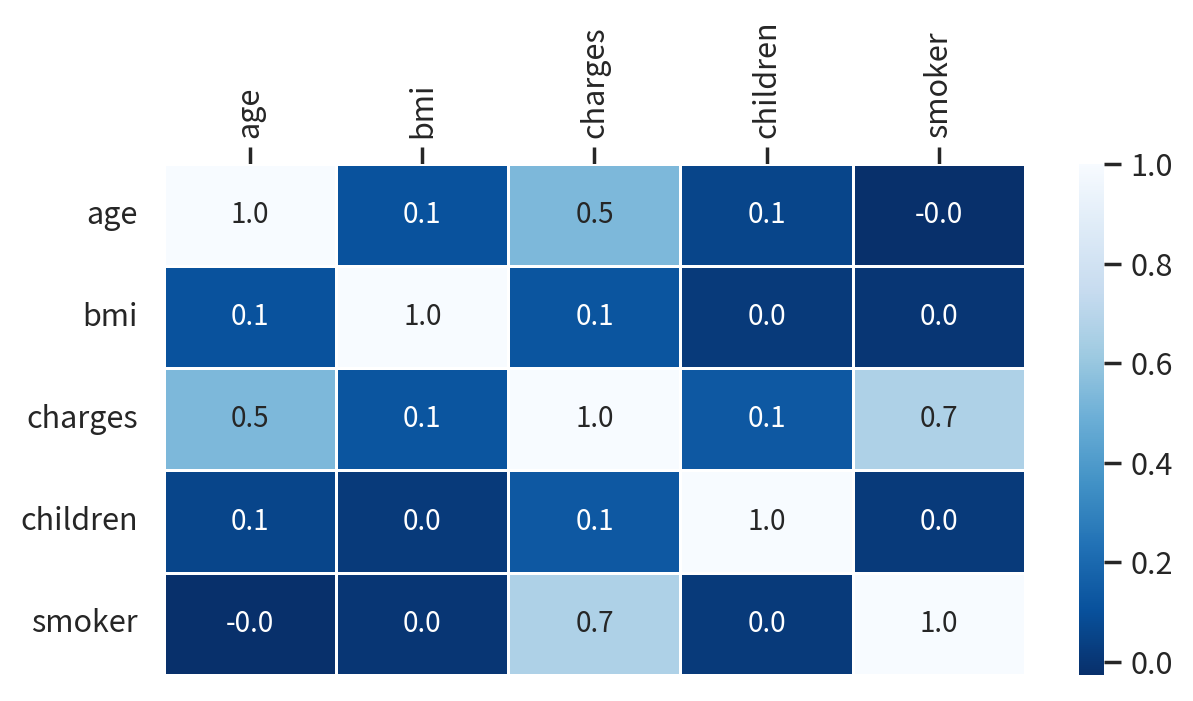

In [112]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r # 대칭

# 4) 대각선 (diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

# corr_matrix
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.1f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':10})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()
plt.close()


smoker와 charges를 제외하면 독립된 모습을 보임

In [113]:
df4 = df3.copy()
yname = 'charges'

x=df4.drop(yname, axis=1)
y=df4[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1065.
Date:                    화, 06 1 2026   Prob (F-statistic):               0.00
Time:                        15:12:47   Log-Likelihood:                -823.84
No. Observations:                1337   AIC:                             1658.
Df Residuals:                    1332   BIC:                             1684.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9855      0.070    100.199      0.0

In [114]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary()의 결과로 생성된 summary 객체
    data : pandas.DataFrame
    종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    #독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != 'const']

    #독립변수 부분 데이터(VIF 계산용)
    indi_df = data.filter(xnames)

    #독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        #한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        #VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df.values, j)

        #유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p:(
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        #한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B": v[1].strip(),
            "표준오차": v[2].strip(),
            "Beta": float(fit.params[name]) * data[name].std() / data[yname].std(ddof=1),
            "t": "%s%s" %(v[3].strip(), stars(p)),
            "p-value": p,
            "공차" : 1/vif,
            "vif": vif
        })
    rdf = DataFrame(variables)

    #summary 표에서 적합도 정보를 key-value로 추출

    result_dict={}
    for i in [0,2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0,n,2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue

                result_dict[key]=value

    #적합도 보고 문자열 생성
    result_report = f"R({result_dict['R-squared']}), R^2({result_dict['Adj. R-squared']}), F({result_dict['F-statistic']}, p={result_dict['Prob (F-statistic)']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})" 

    #모형 보고 문자열 생성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl %(
        rdf['종속변수'][0],
        ",".join(list(rdf['독립변수'])),
        "유의하다" if float(result_dict['Prob (F-statistic)']) <= 0.05 else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<=" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    #변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s %(row['독립변수'],
            row['B'],
            "<=" if float(row['p-value']) < 0.05 else ">",
            row['종속변수'],
            "유의한" if float(row['p-value']) < 0.05 else "유의하지 않은"))
    return rdf, result_report, model_report, variable_reports


In [115]:
rdf,r,m,v = ols_report(tbl1, df3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,charges,age,0.0347,0.001,0.531040,39.431***,0.0,0.132554,7.544067
1,charges,bmi,0.0106,0.002,0.070536,5.243***,0.0,0.124129,8.056136
2,charges,children,0.1009,0.010,0.132388,9.892***,0.0,0.556117,1.798184
3,charges,smoker,1.5425,0.030,0.678104,50.694***,0.0,0.801753,1.247267


charges에 대하여 age,bmi,children,smoker로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,1332) = 1065., p <= 0.05).


In [116]:
df5 = df4.copy()
yname = 'charges'

x=df5.drop([yname,'bmi'], axis=1)
y=df5[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,charges,age,0.0352,0.001,0.538740,39.848***,0.0,0.532387,1.878332
1,charges,children,0.1013,0.010,0.132964,9.838***,0.0,0.583668,1.713302
2,charges,smoker,1.5435,0.031,0.678561,50.232***,0.0,0.822106,1.216388


charges에 대하여 age,children,smoker로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,1333) = 1384., p <= 0.05).


bmi를 제외한 나머지 변수들 공선성 합격
- age와 bmi가 모델에 주는 정보는 서로 독립적이기 때문에 나이는 세월에 따른 신체, 노화 됨을 의미하고 bmi는 현재의 신체 관리 상태를 의미하고 있음
- 따라서 두 변수의 의미가 다르므로 각각 독립적으로 계산할 수 있기 때문에 모델의 설명력이 올라감
- 공선성이 조금이라도 발생하는 듯한 bmi를 제거함으로써 모델의 안정성을 높임

### 미션8. 어떤 변수가 의료비와 가장 가까울까?
- charges와 age, bmi, children의 상관을 계산한다.
- Pearson과 Spearman을 모두 계산하고, 비교해 무엇이 더 적합한지 이유를 적으세요.
- 각 변수의 관계를 의료학, 보건학적 언어로 해석하고(예: "나이가 많을수록 의료비 증가", "과체중(높은 BMI)은 의료비와 강한 관계"), 인과성을 말할 수 있는지 비판적으로 평가합니다.

In [117]:
#charges와 연속형 변수들간의 상관 계산
for col in df5.columns:
    if col == 'charges':
        continue

    x = df5[col]
    y = df5['charges']

    pearson_r, pearson_p = pearsonr(x,y)
    print(f"{col}와 charges의 피어슨 상관계수: {pearson_r:.3f}, p-value: {pearson_p:.3f}, {'대립' if pearson_p <= 0.05 else '귀무'}가설 채택")
    
    spearman_r, spearman_p = spearmanr(x,y)
    print(f"{col}와 charges의 스피어만 상관계수: {spearman_r:.3f}, p-value: {spearman_p:.3f}, {'대립' if spearman_p <= 0.05 else '귀무'}가설 채택")



age와 charges의 피어슨 상관계수: 0.527, p-value: 0.000, 대립가설 채택
age와 charges의 스피어만 상관계수: 0.534, p-value: 0.000, 대립가설 채택
bmi와 charges의 피어슨 상관계수: 0.133, p-value: 0.000, 대립가설 채택
bmi와 charges의 스피어만 상관계수: 0.120, p-value: 0.000, 대립가설 채택
children와 charges의 피어슨 상관계수: 0.160, p-value: 0.000, 대립가설 채택
children와 charges의 스피어만 상관계수: 0.132, p-value: 0.000, 대립가설 채택
smoker와 charges의 피어슨 상관계수: 0.666, p-value: 0.000, 대립가설 채택
smoker와 charges의 스피어만 상관계수: 0.664, p-value: 0.000, 대립가설 채택


charges의 비정규성과 이상치 영향을 최소화하기 위해 스피어만 상관계수 선택, 흡연 여부와 나이가 핵심 요인임을 알 수 있음.
- 통계적으로는 유의해보이지만 아직 데이터에 포함되지 않은 개별 이력이나 보험사마다의 차이도 존재할 수 있기 때문에 인과성에 대해 말할 단계는 아님

### 미션 9. 상관관계는 곧 원인일까?
- 상관이 높다 = 원인이다라는 착각을 피하자
- age와 charges의 높은 상관이 정말 나이 자체의 비용을 결정하는가, 아니면 나이가 건강 상태의 대리 변수인가?
- smoker 효과 : 흡연자는 정말 더 많이 병에 걸려서인가? 아니면 보험사의 위험 평가 기준인가?
- 데이터 수집 시점, 의료 접근성 차이 미측정 변수(직업, 교육, 소득)가 결론에 주는 한계를 서술하시오.

- age와 charges는 age 자체가 아닌 노화로 인한 건강 상태의 대리변수라고 볼 수 있음. 
- smoker는 질병 치료비 상승도 있고, 보험사마다 흡연자에 대한 기준이 다를 수 있음. 
- 현재 모형은 소득 수준, 유전적 요인, 의료 접근성 등 많은 사회경제적 변수가 없으므로 상관계수가 높다해서 원인이라고 보기 어려움

### 10. 의료비를 설명하는 회귀모형 설계
- charges(또는 변환값)를 종속변수로 하는 다중선형회귀를 설계한다.
- 변수 선택,변환,범주형 처리 이유를 명확히 한다.

In [118]:
df_final = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True, dtype=int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   bmi               1337 non-null   float64
 2   children          1337 non-null   int64  
 3   charges           1337 non-null   float64
 4   sex_male          1337 non-null   int64  
 5   smoker_1          1337 non-null   int64  
 6   region_northwest  1337 non-null   int64  
 7   region_southeast  1337 non-null   int64  
 8   region_southwest  1337 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 94.1 KB


In [119]:
df6 = df_final.copy()
yname = 'charges'

x=df6.drop([yname,'bmi'], axis=1)
y=df6[yname]
x_input = sm.add_constant(x)
y=np.log1p(y)
fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df6)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,charges,age,0.0352,0.001,0.000041,40.015***,0.000,0.259563,3.852633
1,charges,children,0.1024,0.010,0.000010,9.988***,0.000,0.567084,1.763406
2,charges,sex_male,-0.0673,0.025,-0.000003,-2.719**,0.007,0.530619,1.884591
3,charges,smoker_1,1.5507,0.031,0.000052,50.482***,0.000,0.800033,1.249948
4,charges,region_northwest,-0.0618,0.035,-0.000002,-1.745,0.081,0.585925,1.706703
5,charges,region_southeast,-0.1010,0.034,-0.000004,-2.932**,0.003,0.556748,1.796145
6,charges,region_southwest,-0.1101,0.035,-0.000004,-3.110**,0.002,0.582932,1.715465


charges에 대하여 age,children,sex_male,smoker_1,region_northwest,region_southeast,region_southwest로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(7,1329) = 602.8, p <= 0.05).


- bmi는 vif 계수가 11이므로 삭제
- p-value가 0.05 이상인 sex_male, 각종 지역 변수들은 유의하지 않은 것을 알지만 해당 특성에 따른 의료비 불평등을 알아보기 위해 모델에 포함시키기로 결정

In [120]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 353.0799
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


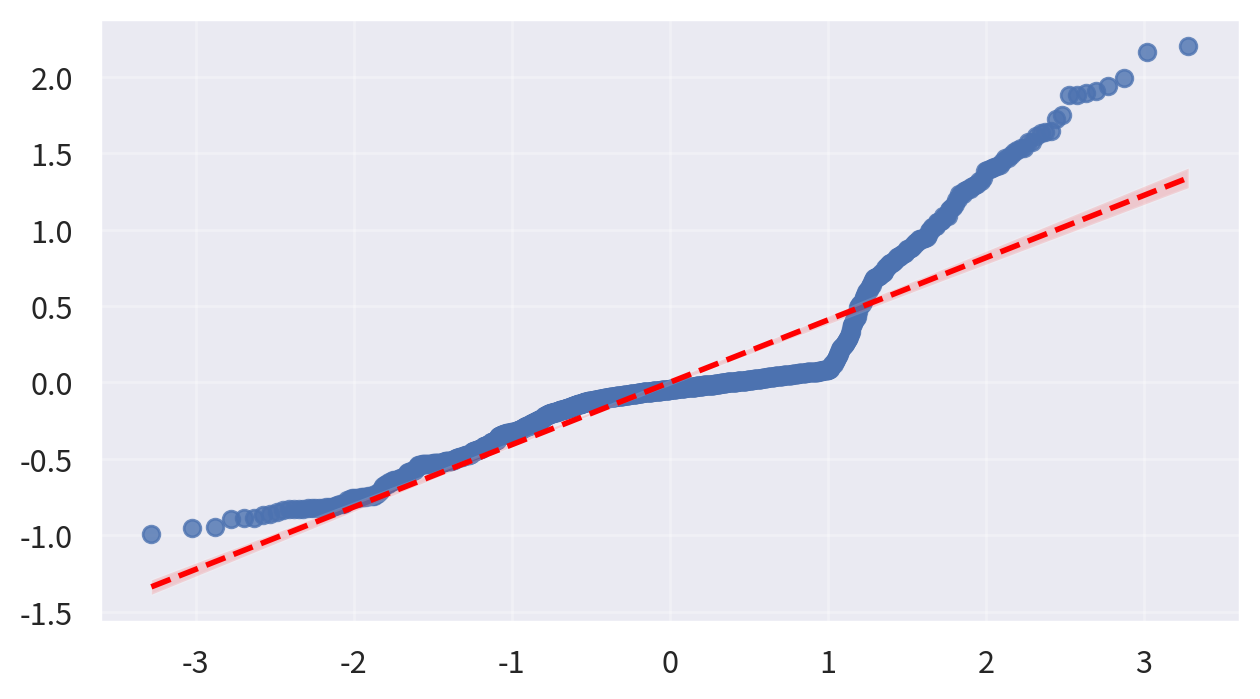

In [121]:
(x, y), _ = probplot(fit.resid)

width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(x=x, y=y, line_kws={'color':'red',
                               'linestyle':'--',
                               'linewidth':2
                               })

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

- 뒤로 갈 수록 선형성에 어긋나는 모습
- bmi와 smoker의 결합 여부를 고려해볼 필요 있음
    - bmi를 넣기 위해 charges와 강한 상관관계를 갖는 smoker 변수와 결합하여 사용
    - bmi와 smoker를 결합하려는 이유는 bmi가 높은 사람이면서 smoker인 경우 보험비가 더 높게 책정될 것이라는 생각

In [122]:
df_final = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True, dtype=int)
df_final['bmi_smoker'] = df_final['bmi'] * df_final['smoker_1']
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   bmi               1337 non-null   float64
 2   children          1337 non-null   int64  
 3   charges           1337 non-null   float64
 4   sex_male          1337 non-null   int64  
 5   smoker_1          1337 non-null   int64  
 6   region_northwest  1337 non-null   int64  
 7   region_southeast  1337 non-null   int64  
 8   region_southwest  1337 non-null   int64  
 9   bmi_smoker        1337 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 104.6 KB


In [151]:
df7 = df_final.copy()
yname = 'charges'

x=df7.drop([yname,'smoker_1'], axis=1)
y=df7[yname]
#charges에 로그 변환 적용
y = np.log1p(y)
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df7)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,charges,age,0.0348,0.001,0.000040,41.238***,0.000,0.129855,7.700915
1,charges,bmi,0.0024,0.002,0.000001,1.161,0.246,0.087059,11.486400
2,charges,children,0.1030,0.010,0.000010,10.553***,0.000,0.552395,1.810297
3,charges,sex_male,-0.0871,0.024,-0.000004,-3.690***,0.000,0.499856,2.000575
4,charges,region_northwest,-0.0704,0.034,-0.000002,-2.086*,0.037,0.529471,1.888676
5,charges,region_southeast,-0.1631,0.034,-0.000006,-4.813***,0.000,0.441450,2.265263
6,charges,region_southwest,-0.1386,0.034,-0.000005,-4.097***,0.000,0.509881,1.961241
7,charges,bmi_smoker,0.0504,0.001,0.000053,53.996***,0.000,0.783487,1.276345


charges에 대하여 age,bmi,children,sex_male,region_northwest,region_southeast,region_southwest,bmi_smoker로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(8,1328) = 599.2, p <= 0.05).


In [124]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 392.7609
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


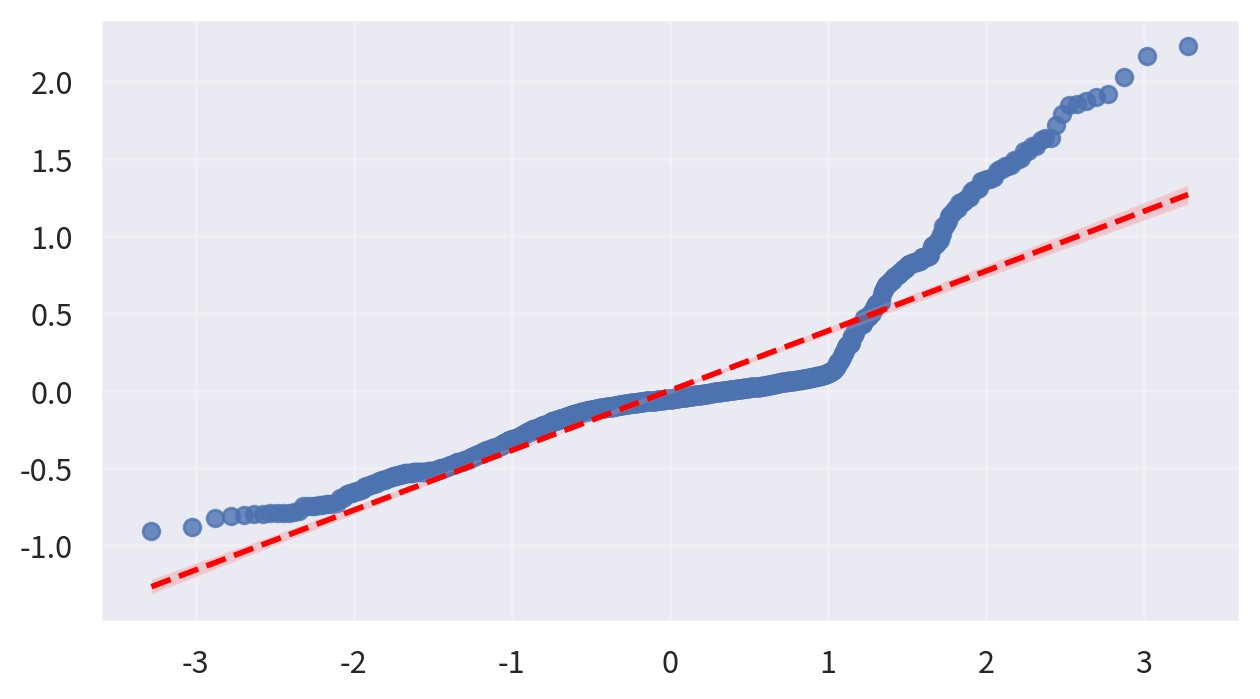

In [125]:
(x, y), _ = probplot(fit.resid)

width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(x=x, y=y, line_kws={'color':'red',
                               'linestyle':'--',
                               'linewidth':2
                               })

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

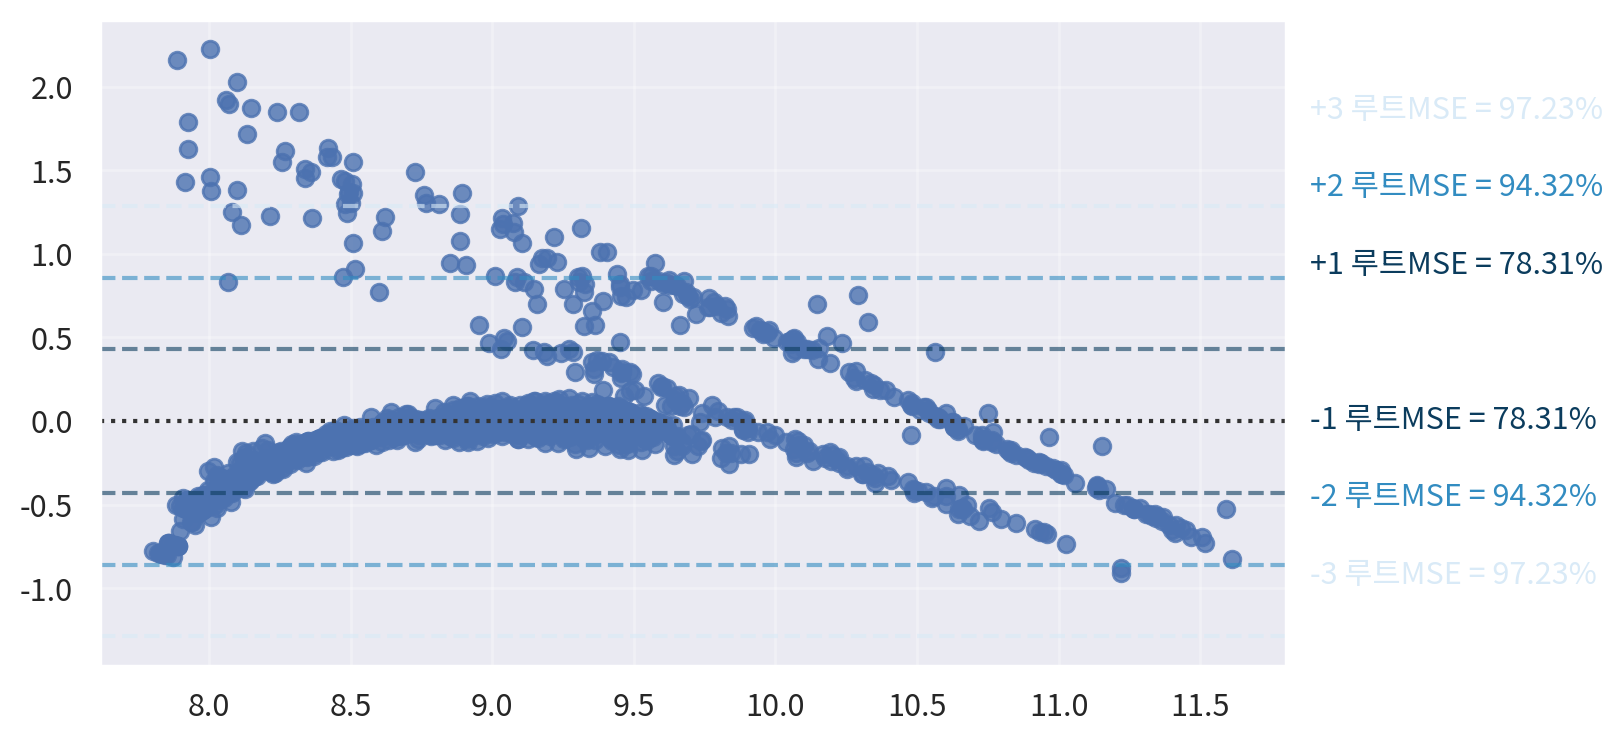

In [126]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid       #잔차

r1 = r[(r>-mse_root) & (r<mse_root)].count() / r.count() * 100
r2 = r[(r>-2*mse_root) & (r<2*mse_root)].count() / r.count() * 100
r3 = r[(r>-3*mse_root) & (r<3*mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0b3C5D", "#328CC1", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, dpi=my_dpi, figsize=figsize, constrained_layout=True)

sb.residplot(x=fit.fittedvalues, y=fit.resid)

ax.grid(True, alpha=0.3)

for i, c in enumerate(colors):
    k= i + 1

    y_pos = k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    
    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

plt.show()
plt.close()

별 차이는 없는듯..
- 고액의 예측은 불확실함 -> 고령층이나 고위험군의 예측이 어렵다는 뜻
- 실제 값보다 예측값이 낮게 형성된다는 것은 모델이 더 낮게 예측함

### 미션 11. 회귀계수는 무엇을 말해주나?
- 계수(또는 표준화 계수)와 신뢰구간, 방향, 크기를 해석한다.
- 나이가 1년 늘면 의료비가 어떻게 변하는가, 흡연자는 비흡연자보다 평균 얼마나 더 높은 비용을 지불하는가 처럼 물리/의료적 의미로 번역한다.
- 변환 변수가 있다면, 변환을 감안한 해석을 명확히 쓴다.
- 표준화 계수(베타)와 비표준화 계수를 병행 제시하고, 단위/변환을 고려한 해석 문장을 명확히 작성합니다.
- 범주형 변수(sex,smoker,region)의 계수는 기준 범주 대비 효과로 명확히 해석하세요.

- 회귀계수와 신뢰구간, 방향, 크기를 해석
    - 회귀 계수는 독립변수가 1단위 변할 때 종속변수가 평균적으로 얼마나 변하는지를 의미
    - 최종 모형에서 확인해보면 age의 경우 1살 많아질수록 의료비는 약 3.49%씩 증가함
    - children의 경우 자녀가 1명 있을때마다 약 10%씩 상승
    - 남성의 경우 여성보다 의료비가 약 8.6% 적게 나타남
    - 흡연자이면서 bmi가 1단위 올라갈때마다 의료비가 5%씩 증가함
        - 이는 담배와 비만의 결합이 치명적인 요인이라고 볼 수 있음
    - 모든 지역에서 B값이 마이너스로 나타남
        - 이는 기준이 된 지역(Northeast)이 다른 지역보다 의료비가 비싸다고 볼 수 있음.

### 미션 12. 모형 진단과 개선
- 잔차 정규성/등분산/선형성, 영향력을 잔차플롯, Q-Q, Cook's distance 등으로 점검
- 문제 지점(예: 극단적 고액 청구, 특정 집단에서의 체계적 오류)과 개선 아이디어(변환, 변수 교체/제거, 강건 회귀)를 제안한다.
- 분석 모형을 보고하고 해석하세요.

In [ ]:
if len(df_final) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value:{p:.4f}")
    violated=p<0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist='norm')
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5

print("정규성 가정 위배 가능성이 있음 (5% 유의수준)" if violated else "정규성 가정 위배 근거 없음 (5% 유의수준)")

Shapiro-Wilk statistic: 0.8138, p-value:0.0000
정규성 가정 위배 가능성이 있음 (5% 유의수준)


In [128]:
# Breusch-Pagan Test
names = ['LM statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value','value']

print(f"Breusch-Pagna statistic: {bp.loc['F Statistic','value']:.3f}, p-value: {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch-Pagna statistic: 9.334, p-value: 0.000
이분산성 존재(등분산 아님)


In [129]:
dw = durbin_watson(fit.resid)

if 1.5<= dw<= 2.5:
    interpretation = "잔차는 독립성을 만족함(자기상관 없음)"
elif dw<1.5:
    interpretation = "잔차는 양(+)의 자기상관이 존재할 가능성 있음(독립성 위반)"
else:
    interpretation = "잔차는 음(-)의 자기상관이 존재할 가능성 있음(독립성 위반)"

print(f"Durbin-Watson: {dw:.3f}")
print(interpretation)

Durbin-Watson: 2.035
잔차는 독립성을 만족함(자기상관 없음)


- 데이터가 45도 직선을 잘 따르다가 고액에서 튐
- 해당 모델은 정규성을 만족하지 않을 가능성이 있고 이분산성이 존재하지만 잔차의 독립성은 만족함. 현재 사용된 데이터들을 기반으로 예측을 했을 때는 고액의 사용자를 제외하면 충분히 통계적 신뢰성을 확보한 모델이라고 볼 수 있음.

### 미션 13. 같은 나이인데 왜 의료비는 다를까?
- age가 같은 두 가상의 개인을 설정하고(예: A는 비흡연 저 BMI, B는 흡연 고 BMI), 다른 변수 차이로 의료비 차이를 설명한다.
- 비전공자에게 이야기하듯, 모델이 설명하는 것과 못하는 것을 구분해 제시한다.
- 이야기의 흐름을 데이터 관찰 -> 회귀계수 -> 의료비 차이 설명 순서로 연결한다.
- 예시 틀: 두 사람 모두 40세이지만, A는 흡연하지 않고 BMI가 25인 반면 B는 흡연자이고 BMI가 35입니다. 모델에 따르면 B의 예상 의료비는 A보다 훨씬 높습니다. 왜냐하면 흡연이 [계수] 만큼 비용을 증가시키고, BMI 1 증가가 [계수]만큼 증가시키기 때문입니다. 하지만 이 모델은 개인의 건강 이력, 유전 요인, 직업 스트레스 같은 정보를 담지 못합니다.
- 모델이 설명하지 못한 요인(개인 건강 이력, 유전 요인, 사회경제적 지위, 의료 접근성 등)의 가능성도 덧붙여 설득력을 높입니다.

In [149]:
# 가상의 데이터 설정
test_data = DataFrame({
    'age': [40,40],
    'bmi' : [25,35],
    'children': [0,0],
    'sex_male' : [0,0],
    'smoker_1' : [0,1],
    'region_northwest' : [0,0],
    'region_southeast' : [0,0],
    'region_southwest' : [0,0]
})

test_data['bmi_smoker'] = test_data['bmi'] * test_data['smoker_1']

x_test = test_data[[
    'age','bmi','children','sex_male','region_northwest','region_southeast','region_southwest','bmi_smoker']]

x_test_data = sm.add_constant(x_test, has_constant='add')
y_test_pred = fit.predict(x_test_data)
print("예측된 의료비(비흡연자): {:.2f}".format(np.expm1(y_test_pred[0])))
print("예측된 의료비(흡연자): {:.2f}".format(np.expm1(y_test_pred[1])))



예측된 의료비(비흡연자): 6784.80
예측된 의료비(흡연자): 40609.21


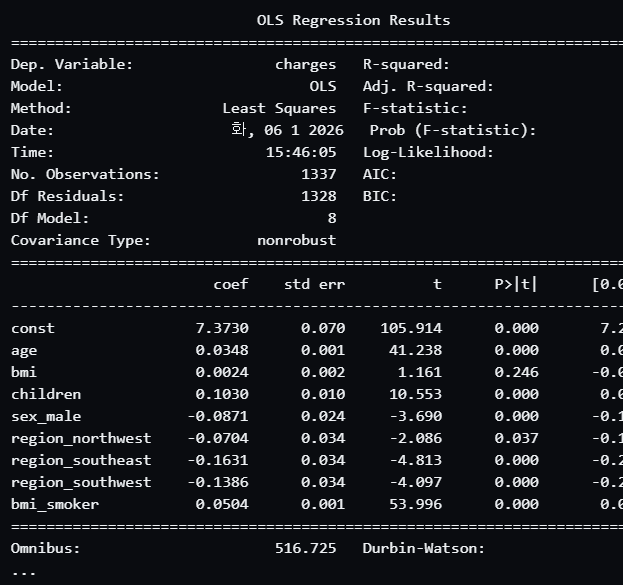

- 비흡연자에 비해 흡연자는 무려 6배에 해당하는 의료비를 더 냄..
    - ~~금연합시다~~
    - 물론 흡연한다고 꼭 의료비를 많이낸다! 이건 아니지만, 흡연자이면서 BMI지수가 높기 때문에 나타난 현상인 것 같음
        - 위는 마지막 학습 데이터의 회귀계수 캡쳐본이다.
        - A가 B보다 적게 내는 이유는 회귀계수에서도 확인할 수 있듯이 흡연자이면서 BMI지수가 1 오를때마다 의료비는 5.1% 가량 추가로 상승한다는 것을 알 수 있다.
        - 하지만 이 모델은 개인의 건강 이력, 유전 요인, 직업 스트레스 같은 정보를 담지 못하기 때문에 꼭 흡연과 비만만이 의료비를 올리는 요인이라고 생각하면 안된다.
        